In [2]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import talib as ta # conda activate cryt310 
from aver5_funcs import get_data
import pickle 
from scipy import stats
import requests
from tqdm import tqdm
from time import sleep, perf_counter
from threading import Thread

In [3]:
with open("trading_pairs_with_highvol_USDTonly.pkl","rb") as f:
    valid_symbols1 = pickle.load(f)
valid_symbols = valid_symbols1+["BUSD","DF","FOR","GNO","MLN","POLS","QUICK","SUPER","GLM","TUSD","PROM","USDC","WNXM"]

In [4]:
len(valid_symbols)

350

In [5]:
dfmpl =get_data(valid_symbols[4]+"USDT","1h")

In [6]:
%%time
data_fetched = [[] for v in valid_symbols]
def task(id):
    #print(f'{id}{valid_symbols[id]}',end="")
    sleep(id*0.02)# 0.05 works
    dfmpl =get_data(valid_symbols[id]+"USDT","1h")
    data_fetched[id]=dfmpl.copy()
    #print(f'{id}{valid_symbols[id]}fin',end="")
    if id%10==0:
        print(f'{id}',end=",")
start_time = perf_counter()
# create and start 10 threads
threads = []
for n in range(len(valid_symbols)):
    t = Thread(target=task, args=(n,))
    threads.append(t)
    t.start()
# wait for the threads to complete
for t in threads:
    t.join()
end_time = perf_counter()
print(f'It took {end_time- start_time: 0.2f} second(s) to complete.')

0,20,10,30,50,40,60,70,140,80,90,130,240,100,170,160,150,120,210,200,180,300,250,110,220,230,190,320,280,290,260,270,340,330,310,It took  12.09 second(s) to complete.
CPU times: total: 12.4 s
Wall time: 12.1 s


In [7]:
data_fetched[:2]

[                         Open      High       Low     Close      Volume
 Date                                                                   
 2023-06-11 03:00:00  25841.22  25850.00  25730.86  25750.28  1006.26589
 2023-06-11 04:00:00  25750.27  25864.32  25718.97  25824.99  1035.45895
 2023-06-11 05:00:00  25824.99  25827.93  25747.28  25766.72  1166.38053
 2023-06-11 06:00:00  25766.71  25770.00  25695.00  25727.51  1010.00082
 2023-06-11 07:00:00  25727.51  25759.99  25634.70  25727.74  1218.85905
 ...                       ...       ...       ...       ...         ...
 2023-07-22 14:00:00  29902.09  29902.09  29864.48  29886.94   297.16156
 2023-07-22 15:00:00  29886.93  29886.94  29828.77  29840.84   510.19490
 2023-07-22 16:00:00  29840.85  29867.64  29835.20  29848.30   269.10948
 2023-07-22 17:00:00  29848.30  29893.67  29847.47  29883.87   675.25551
 2023-07-22 18:00:00  29883.87  29887.73  29860.03  29860.04   249.97345
 
 [1000 rows x 5 columns],
                       

In [8]:
%%time
data=[]
for valid_symbol_i in tqdm(range(len(valid_symbols))):
    #dfmpl =get_data(valid_symbol+"USDT","1h")
    dfmpl=data_fetched[valid_symbol_i]
    data.append((dfmpl.Open*0.5+dfmpl.Close*0.5).values)

100%|██████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1458.35it/s]

CPU times: total: 93.8 ms
Wall time: 262 ms


In [9]:
from collections import Counter
Counter([len(d) for d in data])

Counter({1000: 346, 100: 1, 584: 1, 462: 1, 82: 1})

In [10]:
subset_symbols=[]
for i,(valid_symbol,d) in enumerate(zip(valid_symbols,data)):
    if len(d)==1000:
        subset_symbols.append(valid_symbol)

In [11]:
len(subset_symbols)

346

In [12]:
with open("9_0_subset_symbols_24hrchange.pkl","wb") as f:
    pickle.dump(subset_symbols,f)

# end of file

In [8]:
%%time
data2 = np.asarray([d for d in data if len(d)==1000])

CPU times: total: 0 ns
Wall time: 3 ms


Text(0.5, 0, 'daily minor ticks')

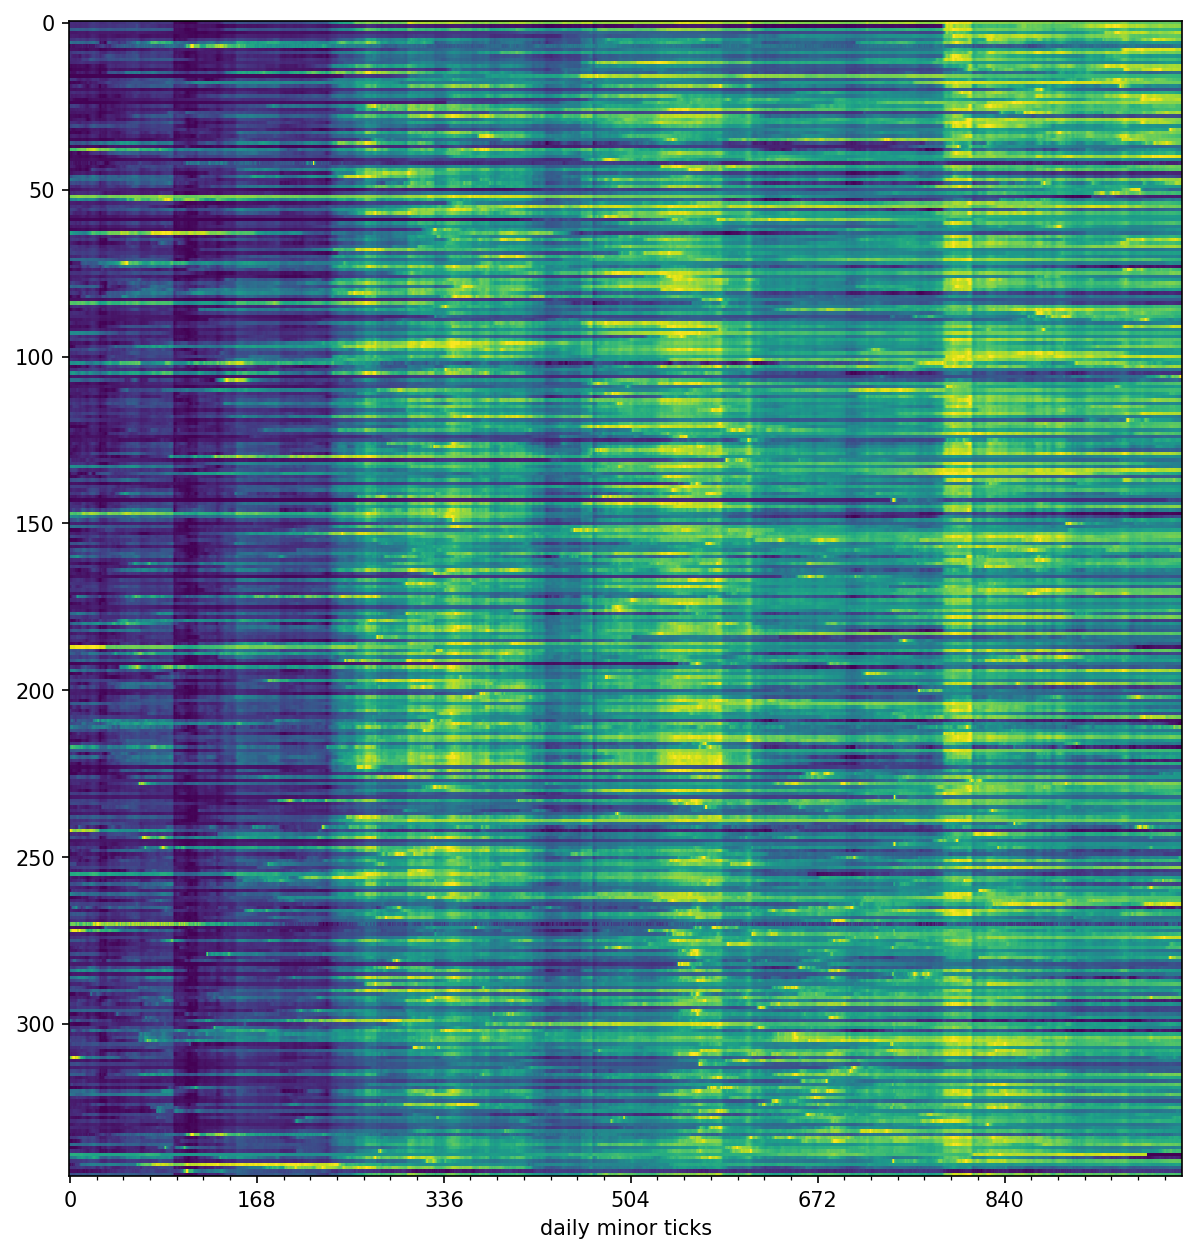

In [9]:
data3 = (data2-np.min(data2,axis=1)[:,np.newaxis])/(np.max(data2,axis=1)[:,np.newaxis]-np.min(data2,axis=1)[:,np.newaxis])
plt.figure(figsize=(10,10),dpi=150)
plt.imshow(data3,interpolation="none",aspect=3)
plt.xticks(ticks=range(0,len(data3[0]),24*7));
plt.xticks(ticks=range(0,len(data3[0]),24),minor=True);
plt.xlabel("daily minor ticks")

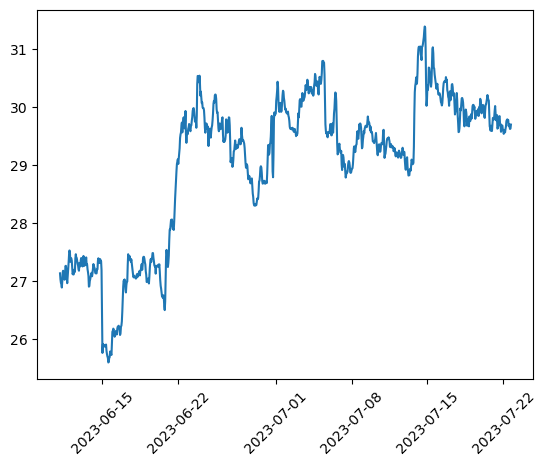

In [10]:
plt.plot(dfmpl.Open*0.5+dfmpl.Close*0.5)
plt.xticks(rotation=45);

# hourly data

In [11]:
hr24change = (data2[:,24:]-data2[:,:-24])/data2[:,:-24]
argsort = np.argsort(-hr24change,axis=0)

Text(0.5, 0, 'daily minor ticks')

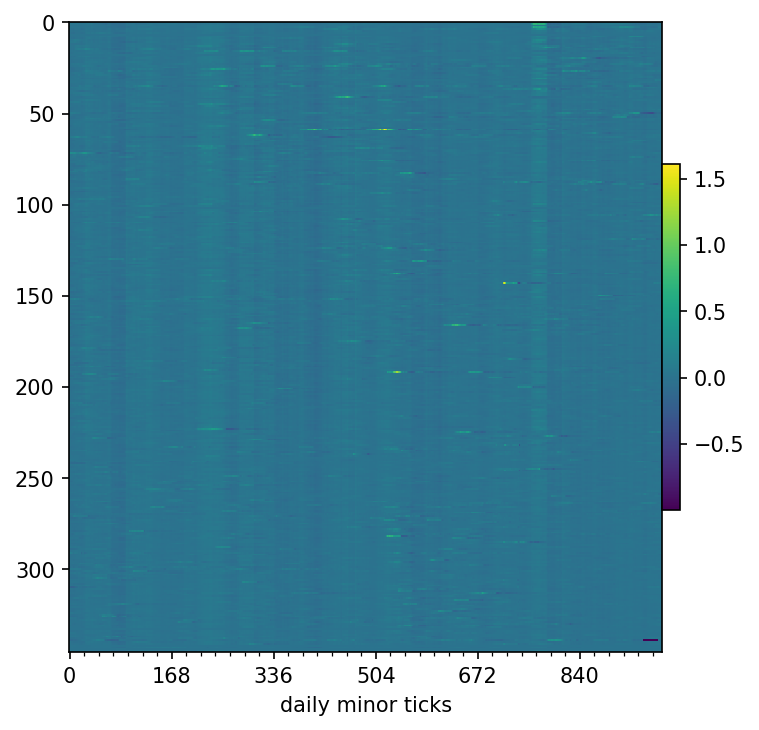

In [12]:
plt.figure(figsize=(6,6),dpi=150)
im = plt.imshow(hr24change,interpolation="none",aspect=3)
plt.colorbar(im,shrink=0.5,pad=0)
plt.xticks(ticks=range(0,len(hr24change[0]),24*7));
plt.xticks(ticks=range(0,len(hr24change[0]),24),minor=True);
plt.xlabel("daily minor ticks")

In [13]:
subset_symbols=[]
for i,(valid_symbol,d) in enumerate(zip(valid_symbols,data)):
    if len(d)==1000:
        subset_symbols.append(valid_symbol)
top10 = argsort[:10,-1]
print([(i,subset_symbols[i]) for i in top10])
len(subset_symbols),len(argsort),top10

[(106, 'STMX'), (225, 'POND'), (143, 'ONG'), (291, 'PERL'), (48, 'LUNA'), (27, 'USTC'), (32, 'TRX'), (338, 'POLS'), (277, 'GAS'), (250, 'CHESS')]


(346,
 346,
 array([106, 225, 143, 291,  48,  27,  32, 338, 277, 250], dtype=int64))

(100.0, 250.0)

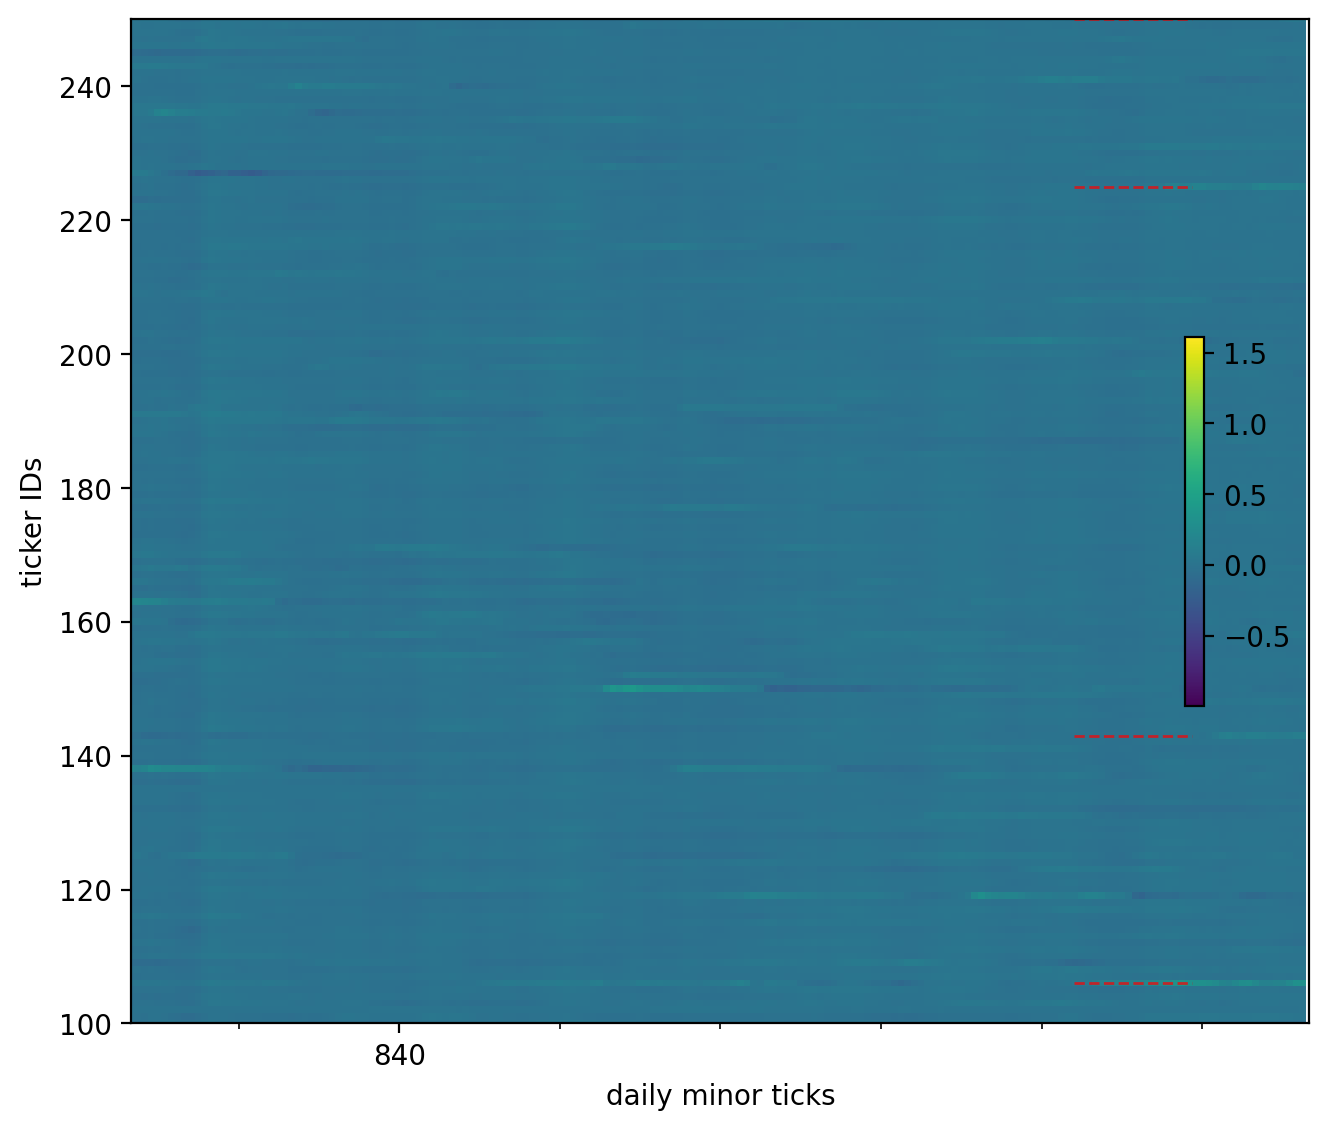

In [14]:
plt.figure(figsize=(8,8),dpi=200)

im= plt.imshow(hr24change,interpolation="none")#,aspect=3)
for hline in top10:
    plt.axhline(hline,xmin=0.8,xmax=0.9,lw=1,ls="--",alpha=0.7,color="r")
plt.colorbar(im,shrink=0.3,pad=-0.1)
plt.xticks(ticks=range(0,len(hr24change[0]),24*7));
plt.xticks(ticks=range(0,len(hr24change[0]),24),minor=True);
plt.xlabel("daily minor ticks")
plt.ylabel("ticker IDs")
plt.xlim(800,976)
plt.ylim(100,250)

In [15]:
argsort,top10
recolored_argsort = np.zeros_like(argsort)*np.nan
for i,label in enumerate(top10):
    recolored_argsort[np.where(argsort==label)]= i+1

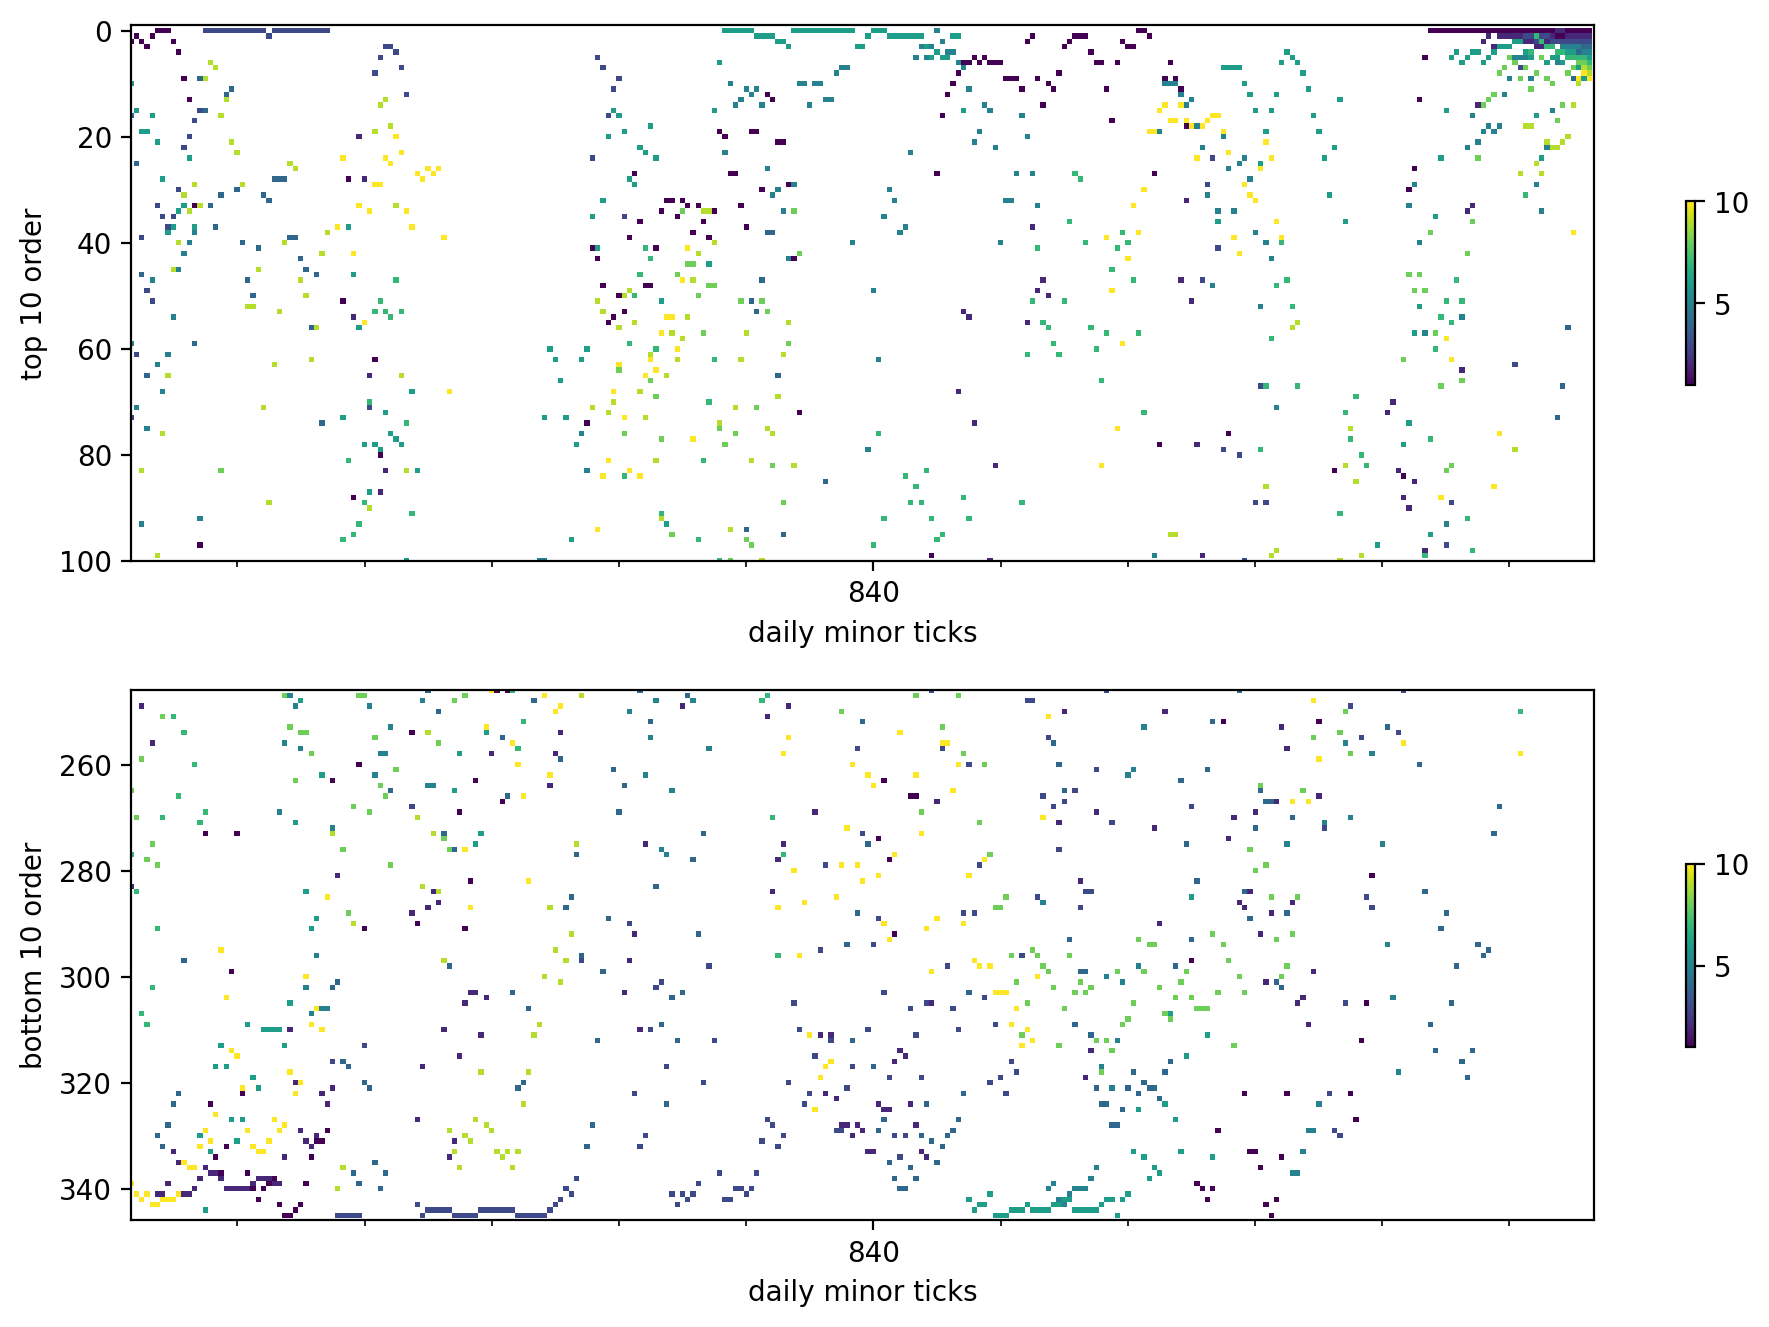

In [16]:
fig,axx = plt.subplots(2,1,figsize=(10,7),dpi=200)
ax=axx[0]
im= ax.imshow(recolored_argsort,interpolation="none")
plt.colorbar(im,ax=ax,shrink=0.3)#,pad=-0.1)
ax.set_xticks(ticks=range(0,len(hr24change[0]),24*7));
ax.set_xticks(ticks=range(0,len(hr24change[0]),24),minor=True);
ax.set_xlabel("daily minor ticks")
ax.set_ylabel("top 10 order")
ax.set_xlim(700,976)
ax.set_ylim(100,-1)

ax=axx[1]
im= ax.imshow(recolored_argsort,interpolation="none")
plt.colorbar(im,ax=ax,shrink=0.3)#,pad=-0.1)
ax.set_xticks(ticks=range(0,len(hr24change[0]),24*7));
ax.set_xticks(ticks=range(0,len(hr24change[0]),24),minor=True);
ax.set_xlabel("daily minor ticks")
ax.set_ylabel("bottom 10 order")
ax.set_xlim(700,976)
ax.set_ylim(len(argsort),len(argsort)-100)
plt.tight_layout(h_pad=0.1)

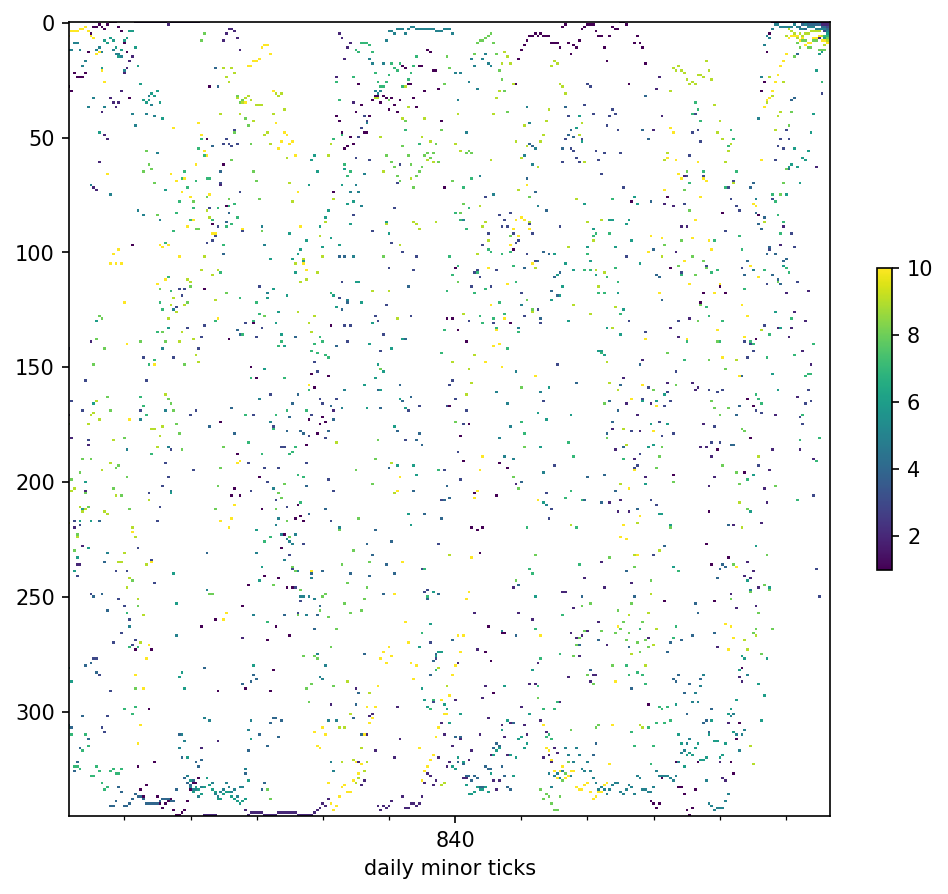

In [99]:
fig,axx = plt.subplots(1,1,figsize=(7,7),dpi=150)
ax=axx#
im= ax.imshow(recolored_argsort,interpolation="none",aspect=1/1.2)
plt.colorbar(im,ax=ax,shrink=0.3)#,pad=-0.1)
ax.set_xticks(ticks=range(0,len(hr24change[0]),24*7));
ax.set_xticks(ticks=range(0,len(hr24change[0]),24),minor=True);
ax.set_xlabel("daily minor ticks") 
ax.set_xlim(700,976) 
plt.tight_layout(h_pad=0.1)

(800.0, 976.0)

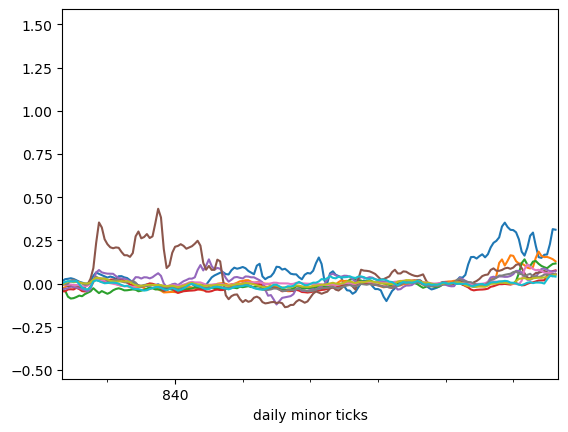

In [17]:
fig,ax=plt.subplots(1,1)
for t in top10:
    ax.plot(hr24change[t])
ax.set_xticks(ticks=range(0,len(hr24change[0]),24*7));
ax.set_xticks(ticks=range(0,len(hr24change[0]),24),minor=True);
ax.set_xlabel("daily minor ticks") 
ax.set_xlim(800,976)

# for each of the top X of each day, look at the daily changes for the previous 3 days

In [18]:
time_intervals_hrs=1
argsort.shape,argsort[:10,72::time_intervals_hrs].shape,hr24change.shape,data2[:,24:].shape

((346, 976), (10, 904), (346, 976), (346, 976))

CPU times: total: 1.56 s
Wall time: 1.97 s


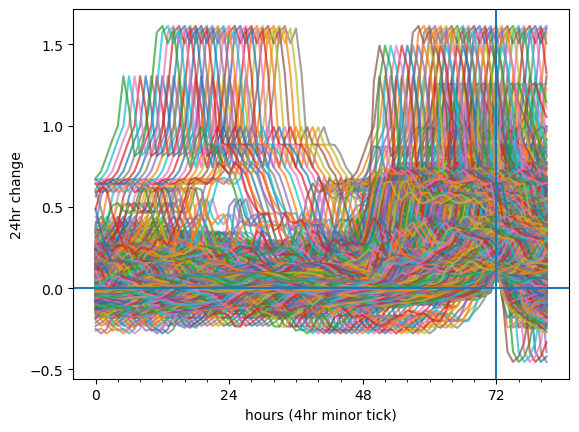

In [19]:
%%time
top_few = 3
fig,ax=plt.subplots(1,1,)#plt.figure()
for ind in np.arange(72,argsort.shape[1]-10,time_intervals_hrs):
    #print(ind)
    ticker_ids = argsort[:top_few,ind]
    #print(ticker_ids)
    for ticker_id in ticker_ids:
        ax.plot(hr24change[ticker_id,ind-72:ind+10],alpha=0.72)
ax.axvline(72)
ax.axhline(0)
ax.set_ylabel("24hr change")
ax.set_xlabel("hours (4hr minor tick)")
ax.set_xticks(ticks=range(0,72+10,24));
ax.set_xticks(ticks=range(0,72+10,4),minor=True);
#ax.set_xlim(70,74)
#ax.set_ylim(-0.1,0.1)

In [20]:
hr1change = (data2[:,24:]-data2[:,23:-1])/data2[:,23:-1]
hr1change.shape

(346, 976)

In [21]:
%%time
top_few = 4
hrly_change_after =[] 
for ind in np.arange(72,argsort.shape[1]-10,time_intervals_hrs): 
    ticker_ids = argsort[:top_few,ind] 
    for ticker_id in ticker_ids: 
        hrly_change_after.append(hr1change[ticker_id,ind:ind+10])

CPU times: total: 15.6 ms
Wall time: 6 ms


CPU times: total: 2.31 s
Wall time: 2.76 s


(-0.1, 0.1)

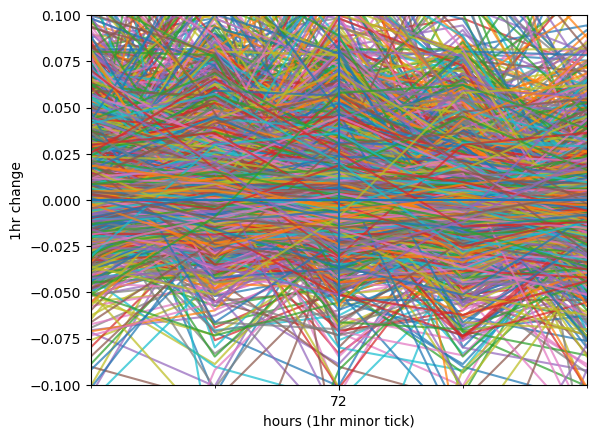

In [22]:
%%time
top_few = 4
hrly_change_after =[]
fig,ax=plt.subplots(1,1,)#plt.figure()
for ind in np.arange(72,argsort.shape[1]-10,time_intervals_hrs):
    #print(ind)
    ticker_ids = argsort[:top_few,ind]
    #print(ticker_ids)
    for ticker_id in ticker_ids:
        ax.plot(hr1change[ticker_id,ind-72:ind+10],alpha=0.72)
        hrly_change_after.append(hr1change[ticker_id,ind:ind+10])
ax.axvline(72)
ax.axhline(0)
ax.set_ylabel("1hr change")
ax.set_xlabel("hours (1hr minor tick)")
ax.set_xticks(ticks=range(0,72+10,24));
ax.set_xticks(ticks=range(0,72+10,1),minor=True);
ax.set_xlim(70,74)
ax.set_ylim(-0.1,0.1)

In [23]:
np.asarray(hrly_change_after).shape

(3576, 10)

In [24]:
np.mean(np.asarray(hrly_change_after),axis=0)*100

array([ 0.73751814,  0.09121398, -0.20037288, -0.17582455, -0.15957028,
       -0.14994777, -0.14672663, -0.12393095, -0.0971033 , -0.07306998])

In [25]:
np.std(np.asarray(hrly_change_after),axis=0)*100

array([3.35753765, 2.95454745, 2.5250043 , 2.3677929 , 2.26763551,
       2.20324998, 2.12183361, 2.07452694, 2.0619437 , 2.07567786])

In [27]:
import time 

In [28]:
int(time.time())*1000

1690034893000

In [29]:
def get_time_before(minutes=10):
    return (int(time.time())-minutes*60)*1000

In [30]:
start_time=1690016301000+60_000-3600_000*4# binance market time= 22/7 12pm
start_time=get_time_before(minutes=0)-2*61*60*1000

In [31]:
%%time
tickerpair="STMXUSDT"
interval="1h"

df_5m_befor = get_data(tickerpair,interval,limit=5,start_time=start_time-3600_000*24)
print("\ndf_5m_befor\n")
print(df_5m_befor)


df_5m_after = get_data(tickerpair,interval,limit=3,start_time=start_time)
print("\ndf_5m_after\n")
print(df_5m_after)

print(df_5m_after.iloc[-1].name)

for i in range(len(df_5m_befor)):
    print(f"{(df_5m_after.iloc[-1].Close - df_5m_befor.iloc[i].Close)/df_5m_befor.iloc[i].Close:.4%}",df_5m_befor.iloc[i].name)


df_5m_befor

                         Open      High       Low     Close       Volume
Date                                                                    
2023-07-21 16:00:00  0.005558  0.005600  0.005376  0.005454  299964719.0
2023-07-21 17:00:00  0.005452  0.005850  0.005440  0.005672  365055867.0
2023-07-21 18:00:00  0.005676  0.005818  0.005645  0.005709  166840803.0
2023-07-21 19:00:00  0.005710  0.005996  0.005692  0.005916  349558822.0
2023-07-21 20:00:00  0.005917  0.006051  0.005798  0.005856  287167829.0

df_5m_after

                         Open     High       Low     Close       Volume
Date                                                                   
2023-07-22 16:00:00  0.007203  0.00756  0.007149  0.007280  481026165.0
2023-07-22 17:00:00  0.007280  0.00741  0.007250  0.007397   35050388.0
2023-07-22 17:00:00
35.6252% 2023-07-21 16:00:00
30.4126% 2023-07-21 17:00:00
29.5673% 2023-07-21 18:00:00
25.0338% 2023-07-21 19:00:00
26.3149% 2023-07-21 20:00:00
CPU time

#  trying to predict the order of top 10 tickers, assuming the current fluctuations are small.

- for all tickers, find the 5m candles in the past 24hrs and then calculate the % change wrt current time. 
- get the order of tickers for the next 5,10,15mins.

- see if this order correspond to the actual results

In [53]:
start_time=1690016301000+60_000-3600_000*4 # binance market time= 22/7 12pm
len(subset_symbols)

346

In [61]:
start_time = 1690021502000 #2023-07-22 18:30:00
offset=8*3600*1000

In [68]:
tickerpair="STMXUSDT"
interval="5m"

df_5m_befor = get_data(tickerpair,interval,limit=5,start_time=start_time-3600_000*24,offset=offset)
df_5m_after = get_data(tickerpair,interval,limit=5,start_time=start_time,offset=offset)

print("\ndf_5m_befor\n")
print(df_5m_befor)
print("\ndf_5m_after\n")
print(df_5m_after)

print("\ncurrent ticker time",df_5m_after.iloc[-1].name,"\n")

for i in range(len(df_5m_befor)):
    print(f"{(df_5m_after.iloc[-1].Close - df_5m_befor.iloc[i].Close)/df_5m_befor.iloc[i].Close:.4%}",df_5m_befor.iloc[i].name)

KeyboardInterrupt: 

In [67]:
data_fetched2 = [[None,None] for v in subset_symbols]
def task2(id): 
    start_time = 1690021502000 #2023-07-22 18:30:00
    offset=8*3600*1000
    sleep(id*0.05)# 0.05 works
    dfmpl0 =get_data(subset_symbols[id]+"USDT","5m",limit=50,start_time=start_time-3600_000*24,offset=offset)
    sleep(0.05)
    dfmpl1 =get_data(subset_symbols[id]+"USDT","5m",limit=50,start_time=start_time,offset=offset)
    data_fetched2[id]=(dfmpl0.copy() ,dfmpl1.copy() )
    if id%10==0:
        print(f'{id}',end=",")
start_time = perf_counter() 
threads = []
for n in range(len(subset_symbols)):
    t = Thread(target=task2, args=(n,))
    threads.append(t)
    t.start() 
for t in threads:
    t.join()
end_time = perf_counter()
print(f'It took {end_time- start_time: 0.2f} second(s) to complete.')

Exception in thread Exception in thread Thread-704 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
Thread-703 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
    raise ValueError(f'line 52 Error: {response.status_

Error: 403Error: 403

Exception in thread Exception in thread Thread-712 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-714 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
Thread-709 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
Exception in thread Thread-705 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    self._target(*self._a

Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403

    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')
ValueError: line 52 Error: 403, counts=11
Exception in thread Thread-717 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-715 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
  File "C:\Users\aatan\

Error: 403Error: 403Error: 403Error: 403

Exception in thread     self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')
ValueError: line 52 Error: 403, counts=11
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    klines = get_klines_live

Error: 403Error: 403Error: 403

Exception in thread Thread-722 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')
ValueError: line 52 Error: 403, counts=11
Exception in thread Thread-723 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\env

Error: 403Error: 403Error: 403

        self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
Exception in thread Thread-718 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')
ValueError: line 52 Error: 403, counts=11
Exception in thread Thread-720 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anacon

Error: 403Error: 403Error: 403

    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
Exception in thread Thread-727 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
    raise ValueError(f'line 52 Error: {response.s

Error: 403Error: 403Error: 403Error: 403Error: 403

        self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
Exception in thread Thread-726 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')
ValueError: line 52 Error: 403, counts=11
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10

Error: 403

Exception in thread Thread-731 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-734 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-735 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\38

Error: 403Error: 403Error: 403

Exception in thread Thread-730 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')
ValueError: line 52 Error: 403, counts=11
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Docu

Error: 403Error: 403Error: 403Error: 403

    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
Exception in thread Thread-736 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-749 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-733 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
  File "C:\Users\aatan\Doc

Error: 403Error: 403Error: 403

    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
Thread-745 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
Exception in thread Thread-757 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", li

Error: 403Error: 403Error: 403Error: 403

    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')
ValueError: line 52 Error: 403, counts=11
Exception in thread Exception in thread Thread-750 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')
Valu

Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403

  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
Exception in thread Thread-740 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')
ValueError: line 52 Error: 403, counts=11
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
Exception in thread Thread-761 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-769 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_in

        self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
Exception in thread Thread-741 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-788 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')
ValueError: line 52 Error: 403, counts=11
Exception in thread Thread-751 (task2):
Traceback (most recent call last):
  Fil

    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
Exception in thread Thread-809 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-818 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users

Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403

  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
Exception in thread Thread-791 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')
ValueError: line 52 Error: 403, counts=11
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6

    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')
ValueError: line 52 Error: 403, counts=11
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
Exception in thread Thread-819 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
Exception in thread Thread-833 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=sta

    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
Exception in thread Thread-843 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-847 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users

Exception in thread Thread-852 (task2)    :
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
Exception in thread Thread-870 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
Exception in thread Thread-856 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')
ValueError: line 52 Error: 403, counts=11
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_d

Exception in thread     self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
Thread-865 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    Exception in thread Thread-854 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
Exception in thread Thread-866 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\Ap

Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403

  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
Exception in thread Thread-860 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    Exception in thread Thread-858 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56

    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
Exception in thread Thread-886 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')
ValueError: line 52 Error: 403, counts=11
    self.run()
  File "C

Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403

  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
Exception in thread Thread-857 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-887 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-879 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-888 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    self.run()
  File "C:\Users\aatan\a

Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403

  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')
ValueError: line 52 Error: 403, counts=11
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')
ValueError: line 52 Error: 403, counts=11
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.

KeyboardInterrupt: 

  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
Exception in thread Thread-901 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')
ValueError: line 52 Error: 403, counts=11
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\G

Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403

  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')
ValueError: line 52 Error: 403, counts=11
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')
ValueError: line 52 Error: 403, counts=11
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
Exception in thread Thread-891 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')

Error: 403Error: 403Error: 403Error: 403

    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')
ValueError: line 52 Error: 403, counts=11
Exception in thread Thread-892 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-896 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start

Error: 403Error: 403Error: 403Error: 403

Exception in thread Thread-874 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
Exception in thread Thread-916 (task2):
Traceback (most recent call last):
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 1016, in _bootstrap_inner
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')
ValueError: line 52 Error: 403, counts=11
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
    self.run()
  File "C:\Users\aatan\anaconda3\envs\cryt310\lib\threading.py", line 953, in run
        self._target(*self._args, **self._kwargs)
  File "C:\Users\aat

Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403Error: 403

    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
    self._target(*self._args, **self._kwargs)
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_10348\3800118676.py", line 6, in task2
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    klines = get_klines_live(tickerpair,interval,limit=limit,start_time=start_time)
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_trader.py", line 56, in get_klines_live
    raise ValueError(f'line 52 Error: {response.status_code}, counts={counts}')
ValueError: line 52 Error: 403, counts=11
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
  File "C:\Users\aatan\Documents\Github\cryptotradr\aver5_funcs.py", line 37, in get_data
    klines = ge

# end of file

In [57]:
(hr24change>0.03)*1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [4]:
tickerpair = tradingpairs[-100:][4]["symbol"]
tickerpair="WRXUSDT";interval="5m"
#tickerpair="ETCUSDT";interval="5m"
#tickerpair="LTCUSDT";interval="5m"

In [9]:
from tqdm import tqdm
limit=1000

In [151]:
res_list=[]
for ind in tqdm(range(len(tradingpairs))):
    #if ind%5!=0 :continue
    tickerpair = tradingpairs[ind]["symbol"]
    
    dfmpl = get_data(tickerpair,"1h",limit=limit)
    #print(len(dfmpl))
    dfmpl=dfmpl.iloc[-limit:]
    x=dfmpl.Volume.iloc[:-1].values
    y=((dfmpl.High-dfmpl.Low)*0.5/(dfmpl.High+dfmpl.Low)).iloc[1:].values
    selected= (y!=0) & (x!=0)
    res = stats.linregress(np.log(x[selected]),np.log( y[selected]))
    #print(f"R-squared: {res.rvalue**2:.6f}")
    diff_max=-9999;percentile_max=0
    for percentile in [95,96,97,98,99]:
        selected_per=x>np.percentile(x,percentile)
        diff = np.mean([ (dfmpl.Close.iloc[i]-dfmpl.Open.iloc[i])/dfmpl.Open.iloc[i]*100 for i in np.where(selected_per)[0]+1])
        if diff>diff_max:
            diff_max=diff;percentile_max=percentile
    res_list.append((res.rvalue**2,percentile_max,diff_max))
    

100%|████████████████████████████████████████████████████████████████████████████████| 819/819 [02:50<00:00,  4.81it/s]


In [12]:
import datetime

In [27]:
ddt=datetime.datetime.utcnow()
ddt.timestamp()

1689663506.08158

'1689663506'

In [59]:
dfmpl = get_data(tickerpair,"1h",limit=3,start_time=f"{int(ddt.timestamp())*1000+9*3600*1000}")

KeyboardInterrupt: 

In [ ]:
dfmpl

In [6]:
# with open("9_0_0_analysisdata/linregress_diffmax.pkl","wb") as f:
#     pickle.dump(res_list,f)
with open("9_0_0_analysisdata/linregress_diffmax.pkl","rb") as f:
    res_list = pickle.load(f)

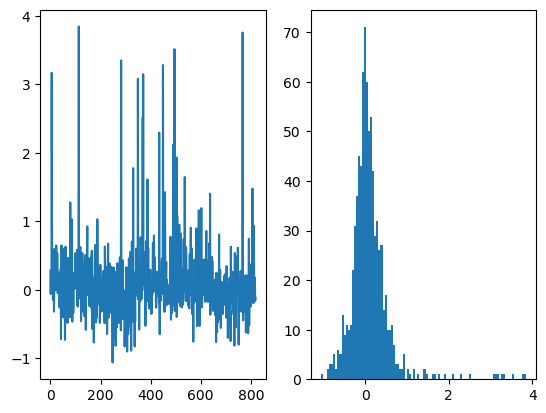

In [7]:
fig,axx=plt.subplots(1,2)
axx[0].plot(np.asarray(res_list)[:,2])
axx[1].hist(np.asarray(res_list)[:,2],bins=100);

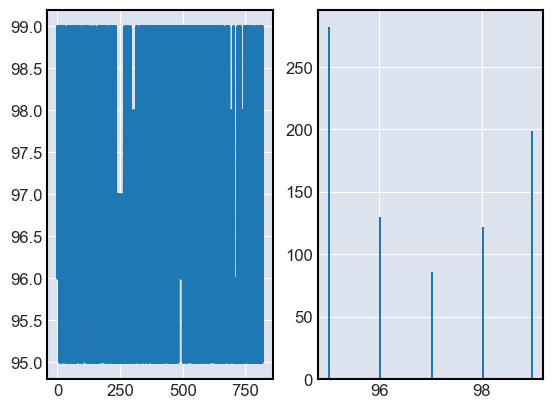

In [153]:
fig,axx=plt.subplots(1,2)
axx[0].plot(np.asarray(res_list)[:,1])
axx[1].hist(np.asarray(res_list)[:,1],bins=100);

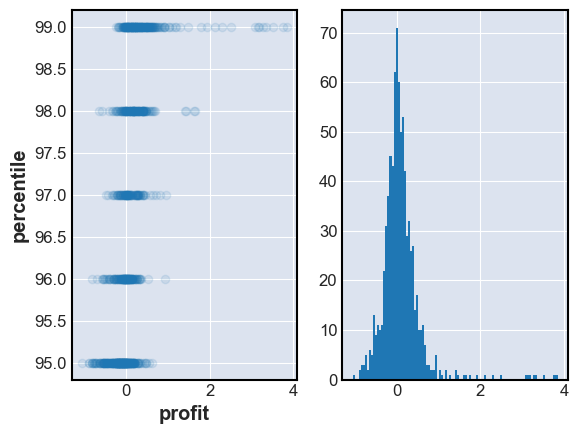

In [158]:
fig,axx=plt.subplots(1,2)
axx[0].scatter(np.asarray(res_list)[:,2],np.asarray(res_list)[:,1],alpha=0.1)
axx[0].set_xlabel("profit")
axx[0].set_ylabel("percentile")
axx[1].hist(np.asarray(res_list)[:,2],bins=100);

In [164]:
np.where(np.asarray(res_list)[:,2]>0.4)

(array([  5,   6,  16,  17,  23,  27,  43,  44,  45,  56,  60,  64,  70,
         73,  79,  81,  86, 100, 106, 111, 113, 119, 127, 140, 146, 147,
        152, 153, 159, 163, 165, 177, 178, 179, 181, 187, 217, 230, 277,
        282, 288, 313, 317, 319, 325, 330, 342, 349, 353, 360, 366, 368,
        370, 374, 377, 382, 387, 390, 409, 413, 416, 434, 445, 449, 457,
        458, 462, 479, 486, 487, 491, 493, 495, 498, 503, 506, 514, 518,
        520, 531, 532, 534, 536, 541, 542, 556, 560, 563, 575, 582, 583,
        592, 600, 602, 612, 619, 622, 628, 633, 635, 637, 644, 646, 673,
        720, 736, 746, 748, 767, 792, 806, 809, 812], dtype=int64),)

In [8]:
[tradingpairs[ind]["symbol"] for ind in np.where(np.asarray(res_list)[:,2]>0.4)[0]]

['XRPUSDT',
 'SOLUSDT',
 'DOGEUSDT',
 'MATICUSDT',
 'LINAUSDT',
 'ADAUSDT',
 'CAKEUSDT',
 'USTCUSDT',
 'EGLDUSDT',
 'SANDUSDT',
 'BELUSDT',
 'ROSEUSDT',
 'EOSUSDT',
 'NEARUSDT',
 'BCHUSDT',
 'REEFUSDT',
 'SNXUSDT',
 'FXSUSDT',
 'CRVUSDT',
 'BANDUSDT',
 'XLMUSDT',
 'SUSHIUSDT',
 'KLAYUSDT',
 'MKRUSDT',
 'CKBUSDT',
 'XECUSDT',
 'FLOWUSDT',
 'WAVESUSDT',
 'HOTUSDT',
 'COTIUSDT',
 'IOTAUSDT',
 'LITUSDT',
 'QUICKUSDT',
 'BETHUSDT',
 'CHRUSDT',
 'QTUMUSDT',
 'GLMRUSDT',
 'BSWUSDT',
 'MTLUSDT',
 'FLMUSDT',
 'STORJUSDT',
 'PNTUSDT',
 'XVGUSDT',
 'PROSUSDT',
 'FUNUSDT',
 'FORTHUSDT',
 'BNBETH',
 'XRPBNB',
 'IDEXBNB',
 'AVAXBNB',
 'SOLETH',
 'XRPETH',
 'XRPBTC',
 'BNBBTC',
 'FILBNB',
 'LTCETH',
 'BCHBNB',
 'ADAETH',
 'AVAXETH',
 'STXBNB',
 'DYDXBNB',
 'BSWBNB',
 'VETETH',
 'XLMBNB',
 'FUNBNB',
 'CFXBTC',
 'BETAETH',
 'LINABTC',
 'IDEXBTC',
 'FILETH',
 'JASMYBTC',
 'AVAXBTC',
 'XLMETH',
 'FTMETH',
 'XLMBTC',
 'BCHBTC',
 'STMXBTC',
 'ETCBTC',
 'QNTBTC',
 'OPBTC',
 'MAGICBTC',
 'SNXBNB',
 'FUNETH',

In [165]:
res_list[5]

(0.38898530791702507, 99, 3.1699728311641477)

In [170]:
%%time
ind=5;percentile=99
tickerpair = tradingpairs[ind]["symbol"]
limit=1000
dfmpl = get_data(tickerpair,"1h",limit=limit)
#print(len(dfmpl))
dfmpl=dfmpl.iloc[-limit:]
x=dfmpl.Volume.iloc[:-1].values
y=((dfmpl.High-dfmpl.Low)*0.5/(dfmpl.High+dfmpl.Low)).iloc[1:].values
#selected= (y!=0) & (x!=0)
#res = stats.linregress(np.log(x[selected]),np.log( y[selected]))
selected_per=x>np.percentile(x,percentile)
diff_list=[ (dfmpl.Close.iloc[i]-dfmpl.Open.iloc[i])/dfmpl.Open.iloc[i]*100 for i in np.where(selected_per)[0]+1]
diff = np.mean(diff_list)

CPU times: total: 62.5 ms
Wall time: 208 ms


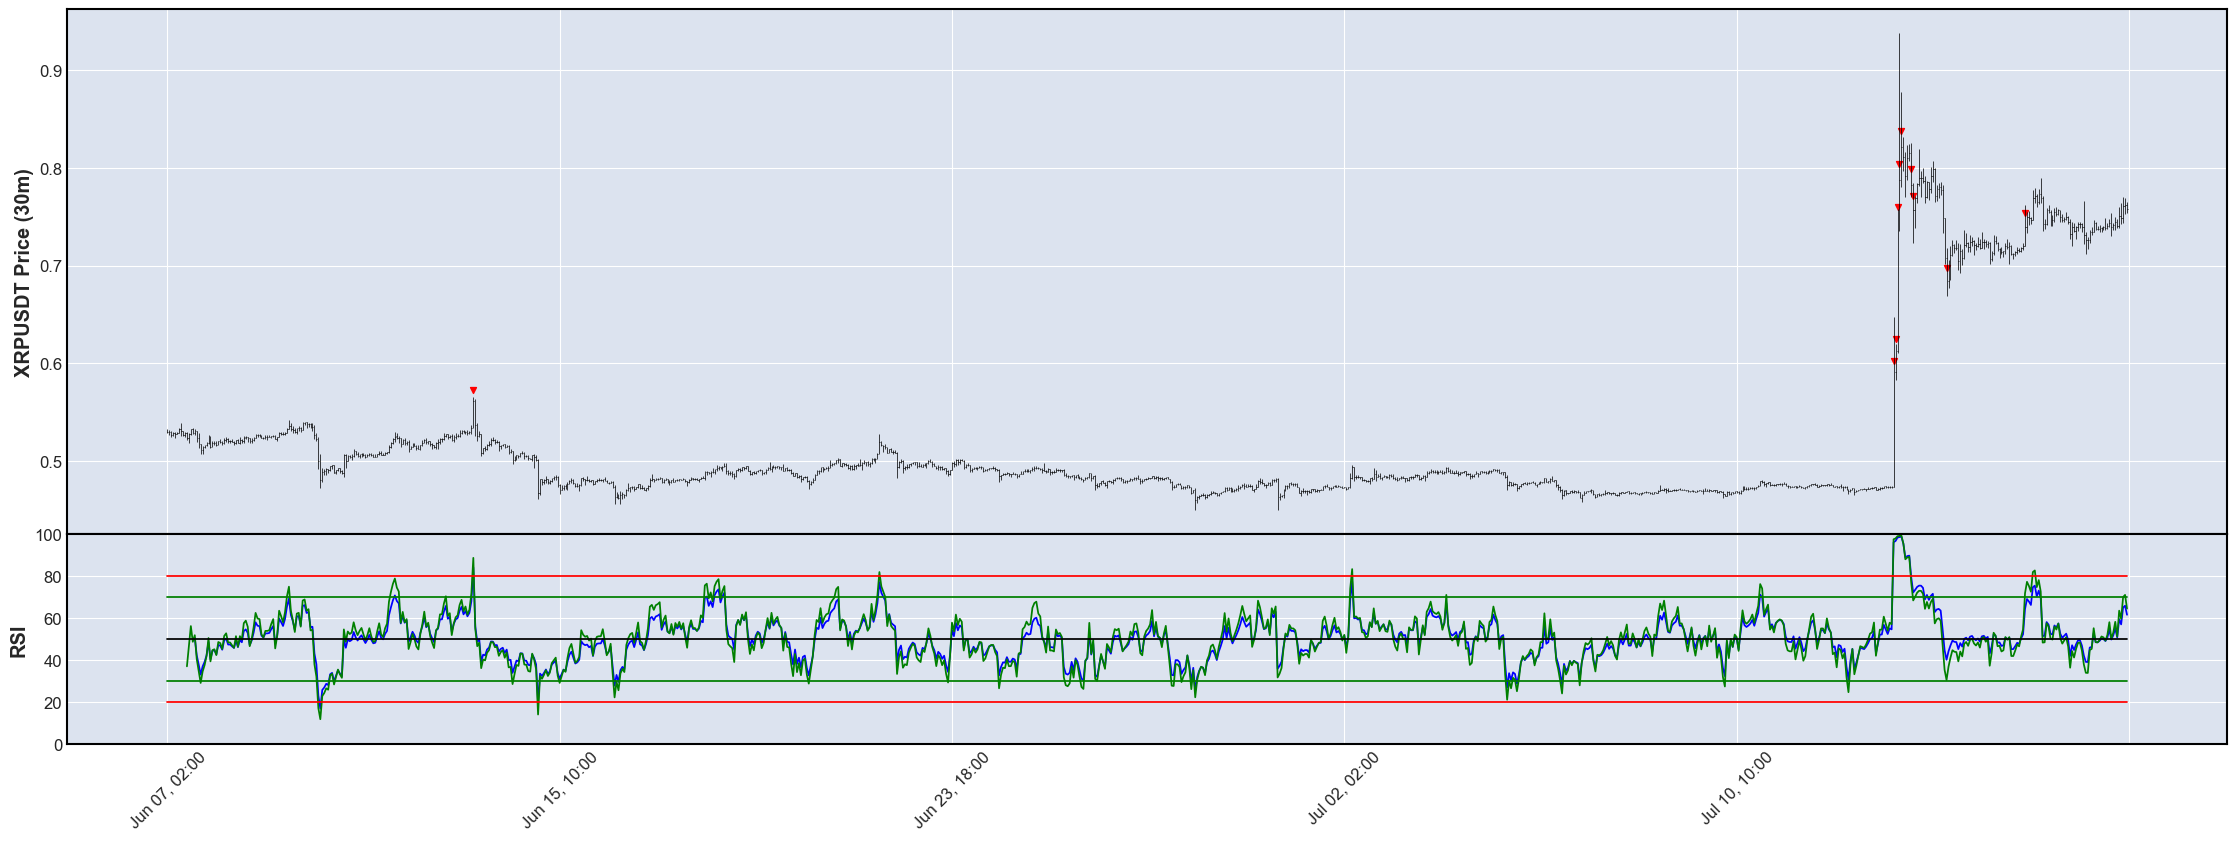

In [173]:
volumeSpike = np.where(selected_per)[0]
scatter = [ dfmpl.Close.iloc[i]*1.02 if i in volumeSpike else np.nan for i in np.arange(len(dfmpl.Close))]
len(volumeSpike)
RSI_close = ta.RSI(dfmpl.Close)
RSI_close10 = ta.RSI(dfmpl.Close,10)
apds = [ #mpf.make_addplot(slo,type='scatter',markersize=200,marker='^'),
    mpf.make_addplot(RSI_close,panel=1,color='b',type='line',ylim=(0,100),ylabel="RSI"),
    mpf.make_addplot(RSI_close10,panel=1,color='g',type='line',ylim=(0,100),secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+70,panel=1,color='g',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+30,panel=1,color='g',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+50,panel=1,color='k',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+80,panel=1,color='r',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+20,panel=1,color='r',type='line', secondary_y=False),
    mpf.make_addplot(scatter,color='r',type='scatter',marker="v"),
    #mpf.make_addplot(vlines,color='r',type='vline'),
       ]

fig, axlist =mpf.plot(dfmpl,addplot=apds,ylabel=f"{tickerpair} Price ({interval})",
        #vlines=dict(vlines=vlines,linewidths=0.01,alpha=0.3,colors="r"),
         returnfig=True,figsize=(20*1.5,7*1.5),warn_too_much_data=2000)

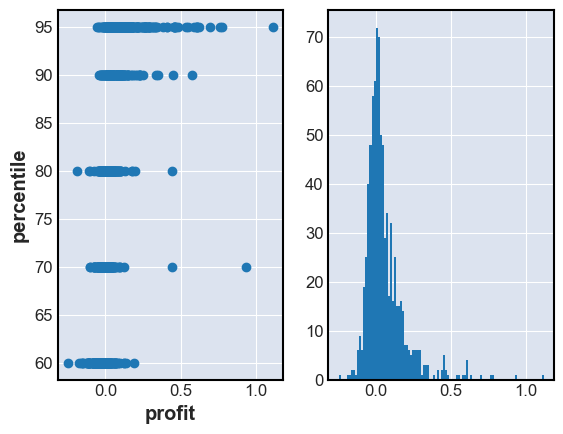

In [148]:
fig,axx=plt.subplots(1,2)
axx[0].scatter(np.asarray(res_list)[:,2],np.asarray(res_list)[:,1])
axx[0].set_xlabel("profit")
axx[0].set_ylabel("percentile")
axx[1].hist(np.asarray(res_list)[:,2],bins=100);

In [69]:
np.where(np.asarray(res_list)>0.5)

(array([ 79, 147, 174, 303, 317], dtype=int64),)

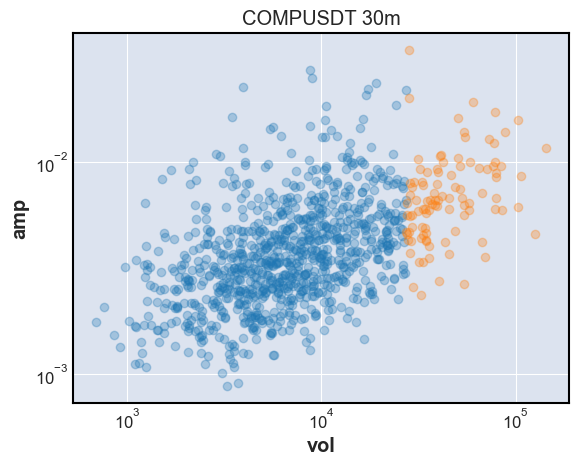

In [130]:
ind=174
tickerpair = tradingpairs[ind]["symbol"]
limit=1000
interval="30m"
dfmpl = get_data(tickerpair,interval,limit=limit)
#print(len(dfmpl))
dfmpl=dfmpl.iloc[-limit:]
x=dfmpl.Volume.iloc[:-1].values
y=((dfmpl.High-dfmpl.Low)*0.5/(dfmpl.High+dfmpl.Low)).iloc[1:].values
selected= (y!=0) & (x!=0)
    
selected_per=x>np.percentile(x,90)
plt.scatter(x[~selected_per],y[~selected_per],alpha=0.3)
plt.scatter(x[selected_per],y[selected_per],alpha=0.3)
plt.title(tickerpair+f" {interval}")
plt.xlabel("vol")
plt.ylabel("amp")
plt.yscale("log")
plt.xscale("log")

Text(0.5, 1.0, 'avg diff=0.13%, trades=100')

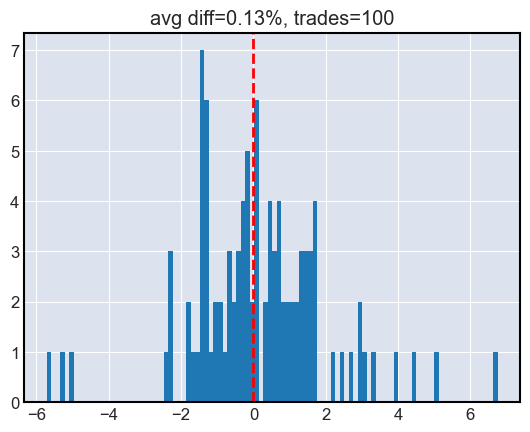

In [133]:
diff = [ (dfmpl.Close.iloc[i]-dfmpl.Open.iloc[i])/dfmpl.Open.iloc[i]*100 for i in np.where(selected_per)[0]+1]
plt.hist(diff,bins=100);
plt.axvline(0,ls="--",c="r")
plt.title(f"avg diff={np.mean(diff):.2g}%, trades={len(diff)}")

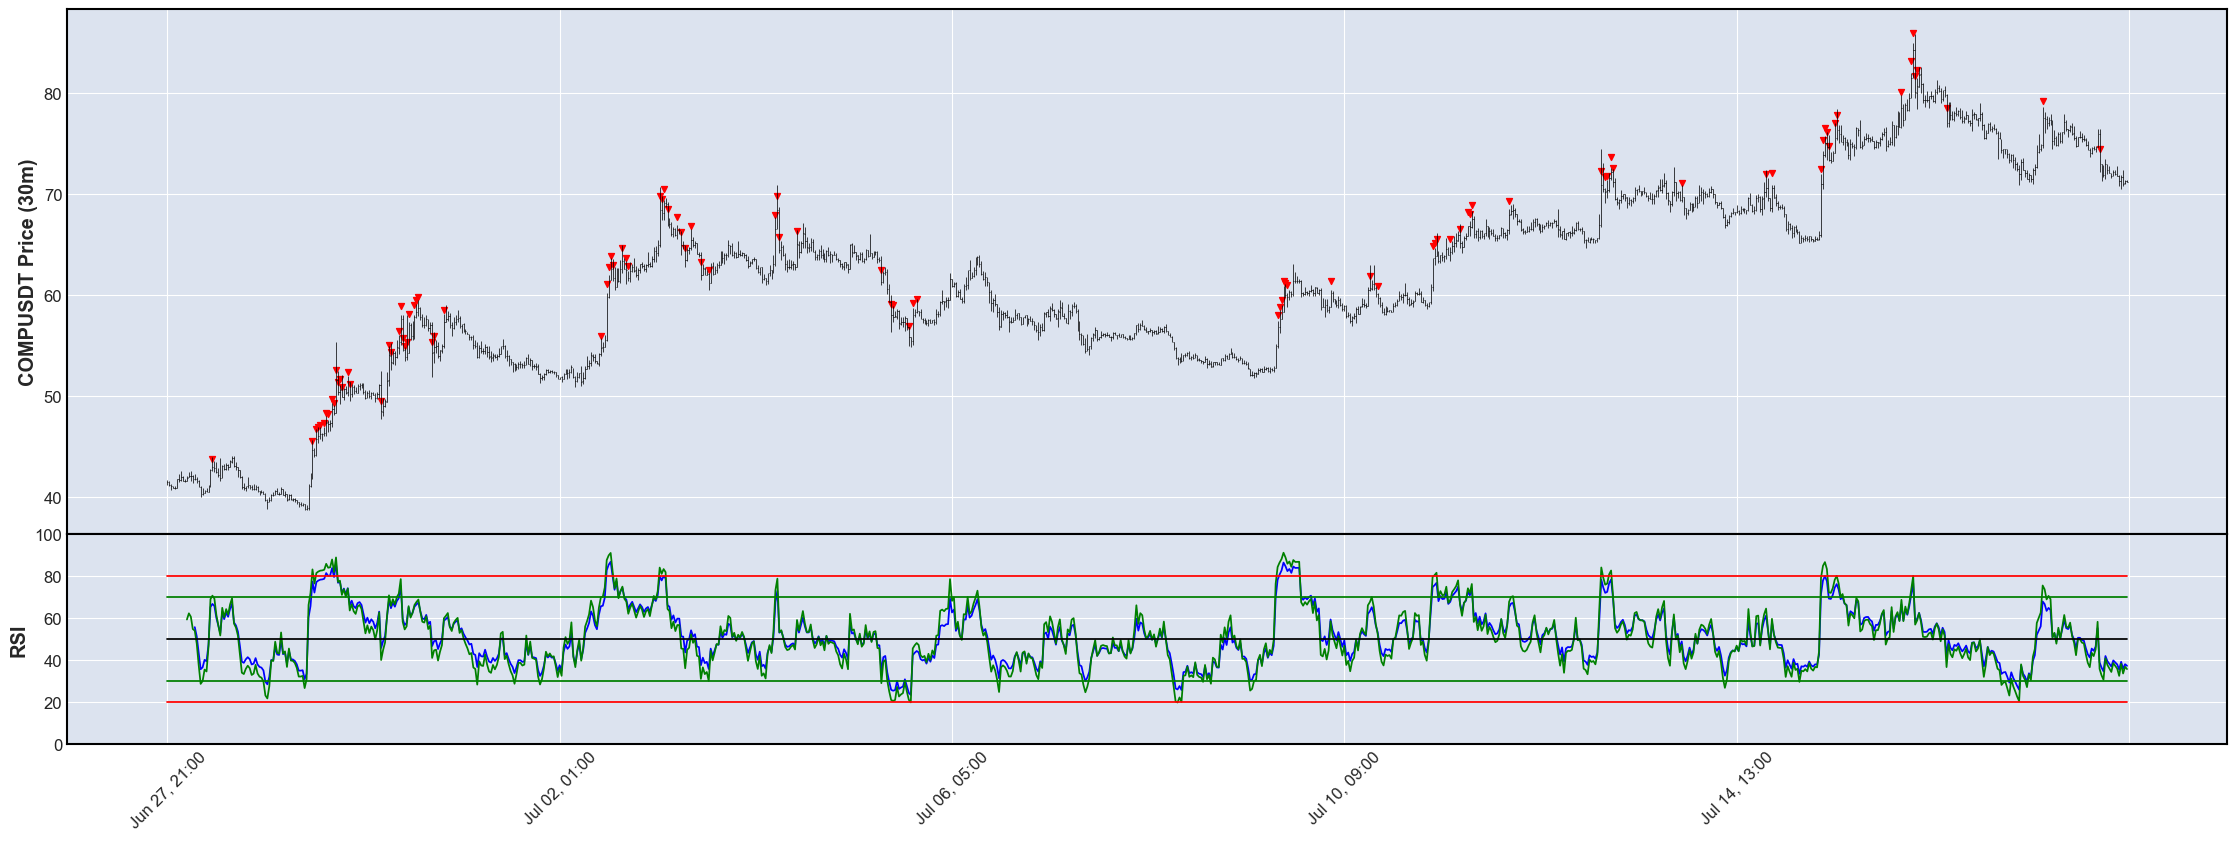

In [132]:
volumeSpike = np.where(selected_per)[0]
scatter = [ dfmpl.Close.iloc[i]*1.02 if i in volumeSpike else np.nan for i in np.arange(len(dfmpl.Close))]
len(volumeSpike)
RSI_close = ta.RSI(dfmpl.Close)
RSI_close10 = ta.RSI(dfmpl.Close,10)
apds = [ #mpf.make_addplot(slo,type='scatter',markersize=200,marker='^'),
    mpf.make_addplot(RSI_close,panel=1,color='b',type='line',ylim=(0,100),ylabel="RSI"),
    mpf.make_addplot(RSI_close10,panel=1,color='g',type='line',ylim=(0,100),secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+70,panel=1,color='g',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+30,panel=1,color='g',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+50,panel=1,color='k',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+80,panel=1,color='r',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+20,panel=1,color='r',type='line', secondary_y=False),
    mpf.make_addplot(scatter,color='r',type='scatter',marker="v"),
    #mpf.make_addplot(vlines,color='r',type='vline'),
       ]

fig, axlist =mpf.plot(dfmpl,addplot=apds,ylabel=f"{tickerpair} Price ({interval})",
        #vlines=dict(vlines=vlines,linewidths=0.01,alpha=0.3,colors="r"),
         returnfig=True,figsize=(20*1.5,7*1.5),warn_too_much_data=2000)

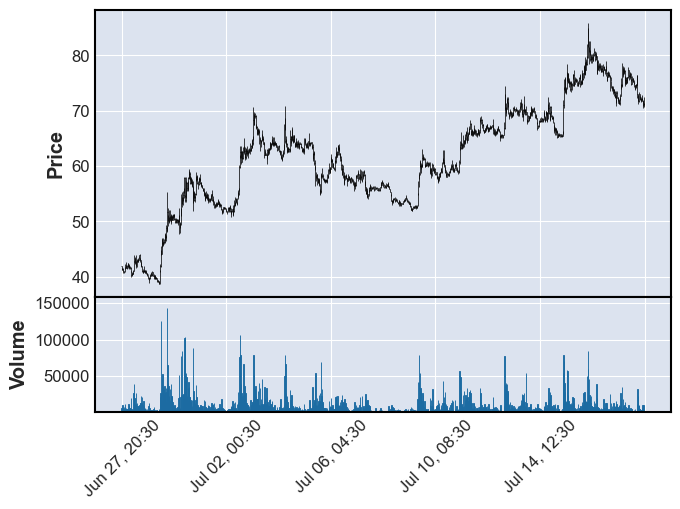

In [96]:
mpf.plot(dfmpl,type="ohlc",warn_too_much_data=2000,volume=True)

In [97]:
ws=10
#volumeSpike = np.where(dfmpl.Volume>(dfmpl.Volume.rolling(ws).mean()+dfmpl.Volume.rolling(ws).std()*2))[0]
volumeSpike = np.where(dfmpl.Volume>(dfmpl.Volume.rolling(ws).mean())*5)[0]
len(volumeSpike)

7

In [98]:
scatter = [ dfmpl.Close.iloc[i]*1.02 if i in volumeSpike else np.nan for i in np.arange(len(dfmpl.Close))]

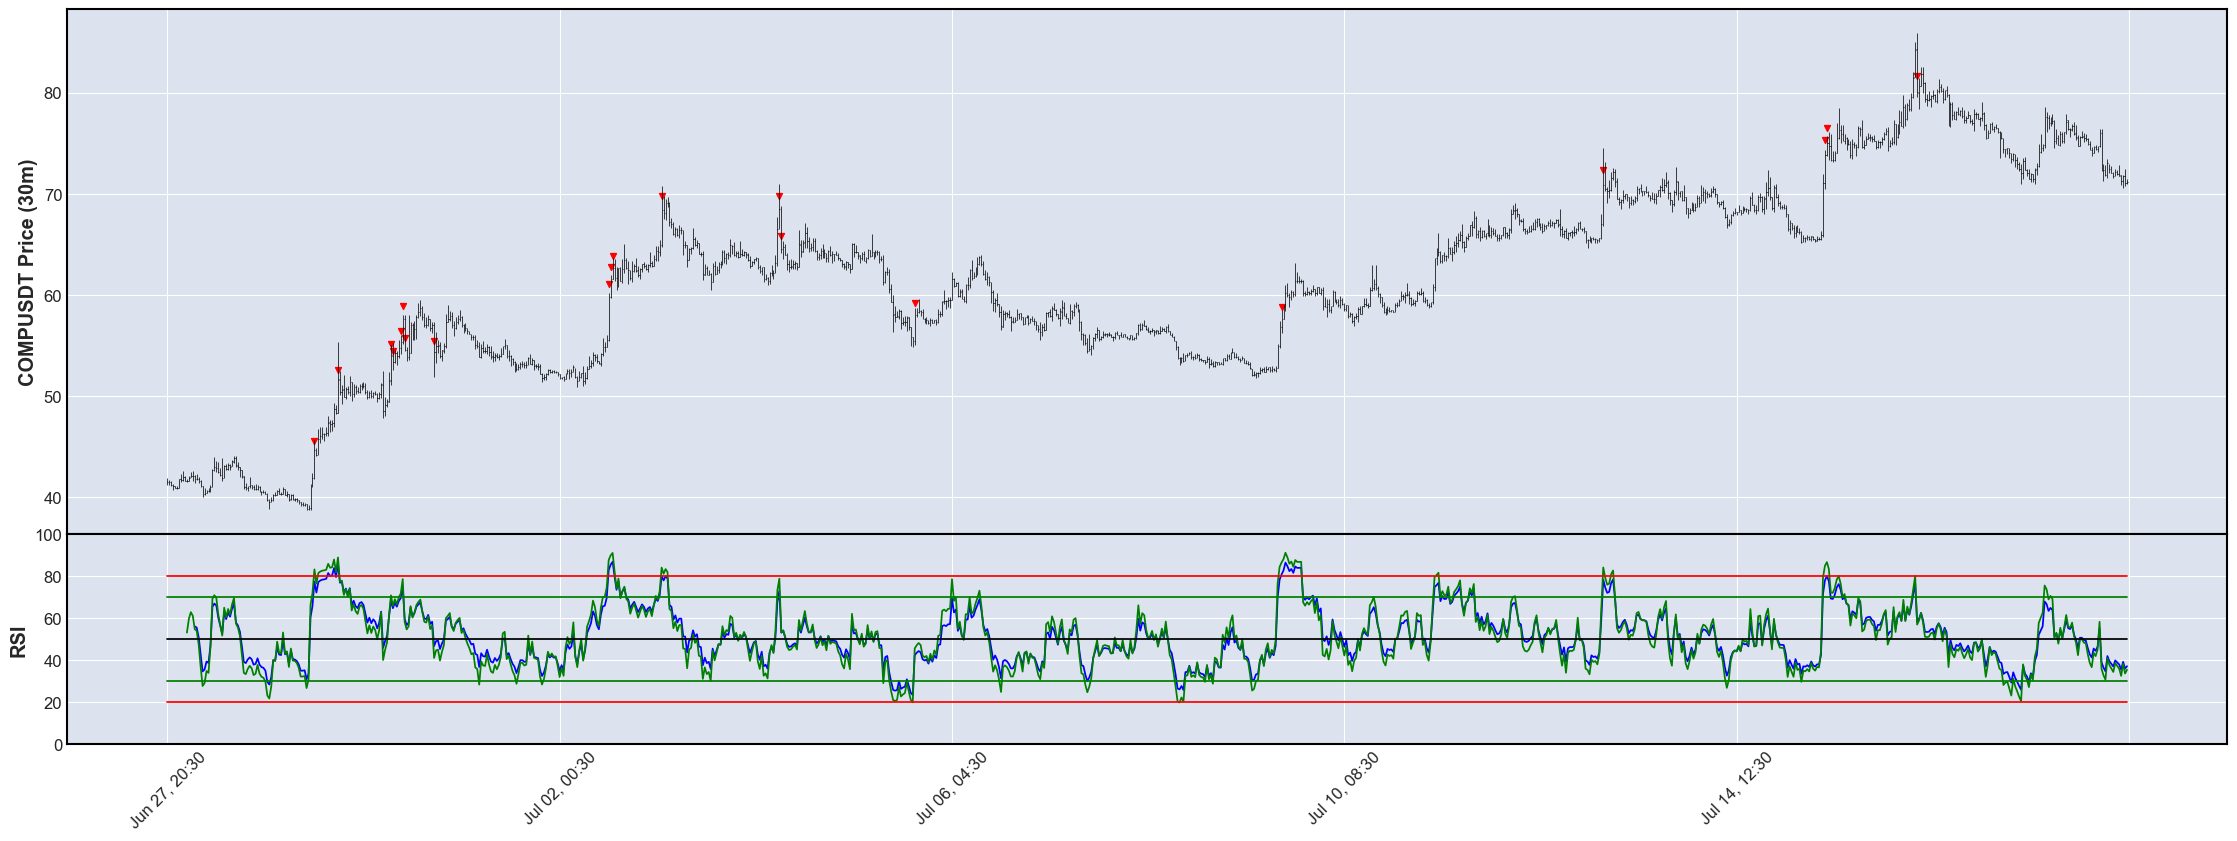

In [100]:
RSI_close = ta.RSI(dfmpl.Close)
RSI_close10 = ta.RSI(dfmpl.Close,10)
apds = [ #mpf.make_addplot(slo,type='scatter',markersize=200,marker='^'),
    mpf.make_addplot(RSI_close,panel=1,color='b',type='line',ylim=(0,100),ylabel="RSI"),
    mpf.make_addplot(RSI_close10,panel=1,color='g',type='line',ylim=(0,100),secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+70,panel=1,color='g',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+30,panel=1,color='g',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+50,panel=1,color='k',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+80,panel=1,color='r',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+20,panel=1,color='r',type='line', secondary_y=False),
    mpf.make_addplot(scatter,color='r',type='scatter',marker="v"),
    #mpf.make_addplot(vlines,color='r',type='vline'),
       ]

fig, axlist =mpf.plot(dfmpl,addplot=apds,ylabel=f"{tickerpair} Price ({interval})",
        #vlines=dict(vlines=vlines,linewidths=0.01,alpha=0.3,colors="r"),
         returnfig=True,figsize=(20*1.5,7*1.5),warn_too_much_data=2000)